# Generative Adversarial Network (GAN)

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable

cuda = torch.cuda.is_available() # True if cuda is available, False otherwise

import matplotlib.pyplot as plt
%matplotlib inline

Let's load the MNIST data set.

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

We define some hyperparameters.

In [3]:
batch =  100

# Discriminator
input_size_d = 28 * 28
hidden_size_d = 256
output_size_d = 1 # probability
learning_rate_d = .0005

# Generator
input_size_g = 128
hidden_size_g = 256
output_size_g = input_size_d # output of generator is a flatten image
learning_rate_g = .0005

epochs = 150

Create a *loader* to feed the data batch by batch during training.

In [4]:
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch, shuffle=True)

Now, we define the architectures of the **discriminator** and **generator**.

In [5]:
discriminator = nn.Sequential(
            nn.Linear(input_size_d, hidden_size_d),
            nn.ReLU(),
            nn.Linear(hidden_size_d, hidden_size_d),
            nn.ReLU(),
            nn.Linear(hidden_size_d, output_size_d),
            nn.Sigmoid())

generator = nn.Sequential(
            nn.Linear(input_size_g, hidden_size_g),
            nn.LeakyReLU(),
            nn.Linear(hidden_size_g, hidden_size_g),
            nn.LeakyReLU(),
            nn.Linear(hidden_size_g, output_size_g),
            nn.Tanh())

discriminator = discriminator.cuda() if cuda else disciminator
generator = generator.cuda() if cuda else generator

We define the loss function and the optimization schemes (here **Adam**) for both the discriminator and the generator.

In [6]:
criterion = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate_d)
optimizer_generator = torch.optim.Adam(params=generator.parameters(), lr=learning_rate_g)

Finally, we train the discriminator and the generator together.

In [7]:
data_size = int(mnist.train_labels.size()[0])

d_x = 0. # average classification probabilities of real data
d_g_z = 0. # average classification probabilities of fake data
loss_d = 0. # average loss of discriminator
loss_g = 0. # average loss of generator

for i in range(epochs):
    for j, (images, _) in enumerate(data_loader):
        # map tensor from (batch, 1, 28, 28) to (batch, 28 * 28)
        images = images.view(images.size(0), -1)
        real_images = Variable(images).cuda() if cuda else Variable(images)
        
        ones = Variable(torch.ones(images.size(0))).cuda() if cuda else Variable(torch.ones(images.size(0)))
        zeros = Variable(torch.zeros(images.size(0))).cuda() if cuda else Variable(torch.zeros(images.size(0)))
        
        # ******************
        # Discriminator step
        # ******************
        discriminator.zero_grad()
        
        noise = Variable(torch.randn(batch, input_size_g)).cuda() if cuda else Variable(torch.randn(batch, input_size_g))
        fake_images = generator(noise) # map input noise to the data space (image)
        discriminator_real = discriminator(real_images)
        discriminator_fake = discriminator(fake_images.detach())
        real_loss_discriminator = criterion(discriminator_real, ones)
        fake_loss_discriminator = criterion(discriminator_fake, zeros)
        
        loss_discriminator = real_loss_discriminator + fake_loss_discriminator
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        
        # ******************
        # * Generator step *
        # ******************
        generator.zero_grad()
        
        noise = Variable(torch.randn(batch, input_size_g)).cuda() if cuda else Variable(torch.randn(batch, input_size_g))
        fake_images = generator(noise) # map input noise to the data space (image)
        discriminator_fake2 = discriminator(fake_images)
        loss_generator = criterion(discriminator_fake2, ones)
        loss_generator.backward()
        optimizer_generator.step()
        
        d_x += torch.sum(discriminator_real).data[0] / data_size
        d_g_z += torch.sum(discriminator_fake).data[0] / data_size
        loss_d += loss_discriminator.data[0] / (data_size / batch)
        loss_g += loss_generator.data[0] / (data_size / batch)
        

    print('Epoch %i/%i, d_loss: %.2f, g_loss: %.2f, D(X)=%.2f D(G(Z))=%.2f' % 
                (i + 1, epochs, loss_d,
                loss_g, d_x, d_g_z))    
    d_x, d_g_z, loss_d, loss_g = 0., 0., 0., 0.    

Epoch 1/150, d_loss: 0.41, g_loss: 4.08, D(X)=0.92 D(G(Z))=0.18
Epoch 2/150, d_loss: 1.16, g_loss: 3.62, D(X)=0.75 D(G(Z))=0.29
Epoch 3/150, d_loss: 0.86, g_loss: 2.31, D(X)=0.78 D(G(Z))=0.26
Epoch 4/150, d_loss: 1.28, g_loss: 2.07, D(X)=0.67 D(G(Z))=0.37
Epoch 5/150, d_loss: 1.04, g_loss: 1.63, D(X)=0.69 D(G(Z))=0.34
Epoch 6/150, d_loss: 0.88, g_loss: 2.41, D(X)=0.76 D(G(Z))=0.26
Epoch 7/150, d_loss: 0.95, g_loss: 2.16, D(X)=0.73 D(G(Z))=0.29
Epoch 8/150, d_loss: 0.89, g_loss: 2.11, D(X)=0.74 D(G(Z))=0.28
Epoch 9/150, d_loss: 0.96, g_loss: 1.81, D(X)=0.71 D(G(Z))=0.30
Epoch 10/150, d_loss: 0.89, g_loss: 2.16, D(X)=0.74 D(G(Z))=0.27
Epoch 11/150, d_loss: 0.77, g_loss: 2.59, D(X)=0.79 D(G(Z))=0.23
Epoch 12/150, d_loss: 0.76, g_loss: 2.66, D(X)=0.79 D(G(Z))=0.23
Epoch 13/150, d_loss: 0.77, g_loss: 2.66, D(X)=0.77 D(G(Z))=0.24
Epoch 14/150, d_loss: 0.89, g_loss: 2.26, D(X)=0.75 D(G(Z))=0.27
Epoch 15/150, d_loss: 0.90, g_loss: 1.95, D(X)=0.73 D(G(Z))=0.28
Epoch 16/150, d_loss: 0.88, g_loss

Let's plot some generated images.

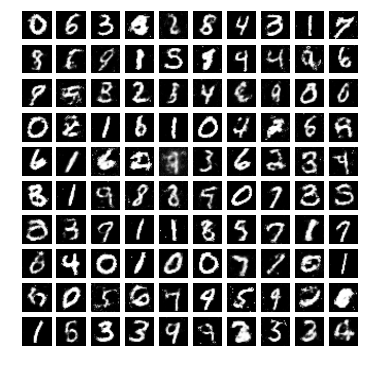

In [8]:
fake_images = fake_images.view(batch, 28, 28).data.cpu().numpy()

fig = plt.figure(figsize=(6, 6))
for i in range(100):
    a = fig.add_subplot(10, 10, i + 1)
    a.axis('off')
    fake_image = fake_images[i - 1]
    a.imshow(fake_image, cmap='Greys_r')